## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果

In [1]:
import os
import keras
from keras.datasets import cifar10
import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [3]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [4]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [5]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [6]:
import tensorflow as tf
import keras.backend as K

# Loss function 定義需要兩層
def combined_loss(gamma=2., alpha=4., ce_weights=0.7, fl_weights=0.3):
    gamma = float(gamma)
    alpha = float(alpha)
    def ce_fl_loss(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        return (ce_weights*ce_loss) + (fl_weights*tf.reduce_mean(reduced_fl))
    return ce_fl_loss

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [7]:
import itertools
results = {}

for ce_w in ce_weights_list:
    print(f"Cross entropy loss weight: {ce_w}")
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(ce_weights=ce_w, fl_weights=1.-ce_w), 
                  metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = (f"Cross entropy loss weight: {ce_w}")
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Cross entropy loss weight: 0.0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (

Epoch 5/30
49/49 [==============================] - 4s 80ms/step - loss: 2.9080 - accuracy: 0.5240 - val_loss: 3.4347 - val_accuracy: 0.4536
Epoch 6/30
49/49 [==============================] - 4s 81ms/step - loss: 2.7690 - accuracy: 0.5431 - val_loss: 3.3782 - val_accuracy: 0.4475
Epoch 7/30
49/49 [==============================] - 4s 81ms/step - loss: 2.6418 - accuracy: 0.5588 - val_loss: 3.2326 - val_accuracy: 0.4794
Epoch 8/30
49/49 [==============================] - 4s 82ms/step - loss: 2.5291 - accuracy: 0.5741 - val_loss: 3.2179 - val_accuracy: 0.4768
Epoch 9/30
49/49 [==============================] - 4s 83ms/step - loss: 2.4228 - accuracy: 0.5858 - val_loss: 3.2195 - val_accuracy: 0.4764
Epoch 10/30
49/49 [==============================] - 4s 85ms/step - loss: 2.3192 - accuracy: 0.6019 - val_loss: 3.1810 - val_accuracy: 0.4758
Epoch 11/30
49/49 [==============================] - 4s 82ms/step - loss: 2.2188 - accuracy: 0.6163 - val_loss: 3.1764 - val_accuracy: 0.4830
Epoch 12/30

Epoch 21/30
49/49 [==============================] - 4s 74ms/step - loss: 1.3146 - accuracy: 0.7267 - val_loss: 2.7810 - val_accuracy: 0.4997
Epoch 22/30
49/49 [==============================] - 4s 74ms/step - loss: 1.2521 - accuracy: 0.7386 - val_loss: 2.8490 - val_accuracy: 0.4852
Epoch 23/30
49/49 [==============================] - 4s 74ms/step - loss: 1.1946 - accuracy: 0.7501 - val_loss: 2.8964 - val_accuracy: 0.4916
Epoch 24/30
49/49 [==============================] - 4s 78ms/step - loss: 1.1385 - accuracy: 0.7618 - val_loss: 2.8383 - val_accuracy: 0.4952
Epoch 25/30
49/49 [==============================] - 4s 75ms/step - loss: 1.0790 - accuracy: 0.7734 - val_loss: 2.9706 - val_accuracy: 0.4840
Epoch 26/30
49/49 [==============================] - 4s 75ms/step - loss: 1.0312 - accuracy: 0.7810 - val_loss: 2.9730 - val_accuracy: 0.4817
Epoch 27/30
49/49 [==============================] - 4s 76ms/step - loss: 0.9806 - accuracy: 0.7923 - val_loss: 2.9988 - val_accuracy: 0.4911
Epoch 

 batch_normalization_13 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 batch_normalization_14 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,742,474
Trainable params: 1,740,682
Non-trainable params: 1,792
_________________________________________________________________
Epoch 1/30
49/49 [==============================] - 8s 124ms/step - loss: 2.2463 - accuracy: 0.2619 - val_loss: 2.1169 - val_accuracy: 0.1993
Epoch 2/30
49/49 [==============================] - 

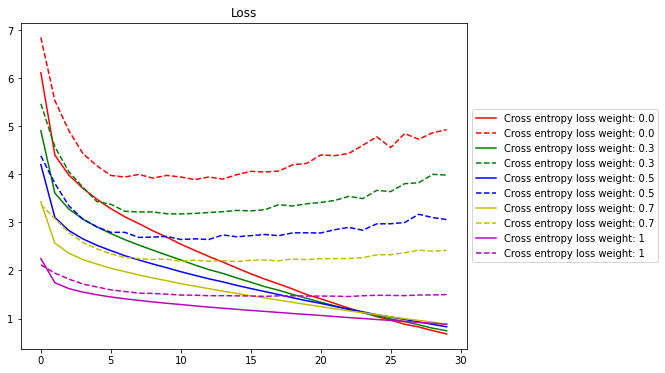

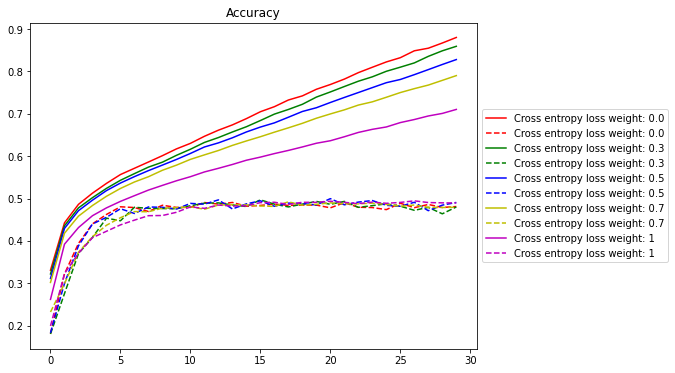

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 筆記
1. Categorical crossentropy 比重越高, loss function 越小, 且 over-fitting 程度越小